In [38]:
from enum import Enum, auto
from datetime import datetime
from plotly.subplots import make_subplots

import plotly.graph_objects as go
import pandas as pd
import numpy as np
import requests
import os

import plotly.express as px

In [39]:
df = pd.read_csv("dataset.csv")

df = df.drop('Unnamed: 0', axis=1)
df.head(10)

,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,5274,08/07/2018,2266,17,27.4,44,1.7,2000,14.0,1.17,0.0,0.0,Yes
1,1185,19/01/2018,648,8,-2.5,50,1.0,1281,-11.5,0.00,0.0,0.0,Yes
2,6473,27/08/2018,886,16,24.7,85,1.2,1143,22.0,0.99,0.0,0.0,Yes
3,602,26/12/2017,127,1,-1.5,62,1.3,2000,-7.8,0.00,0.0,0.0,Yes
4,5656,24/07/2018,735,15,35.8,47,2.2,1029,22.7,1.51,0.0,0.0,Yes
5,3516,26/04/2018,930,11,18.1,42,2.7,1112,4.9,2.17,0.0,0.0,Yes
6,5240,07/07/2018,567,7,19.6,57,1.6,2000,10.8,0.42,0.0,0.0,Yes
7,2413,11/03/2018,666,12,9.2,40,2.6,592,-3.7,2.47,0.0,0.0,Yes
8,2463,13/03/2018,705,14,18.3,43,2.2,1509,5.4,2.43,0.0,0.0,Yes
9,3398,21/04/2018,1315,13,24.6,10,2.7,2000,-9.0,3.31,0.0,0.0,Yes


In [40]:
columns = df.columns.tolist()
snake_cased_columns = ['id',
               'date','rented_bike_count','hour',
               'temperature','humidity','wind_speed','visibility',
               'dew_point_temperature','solar_radiation','rainfall',
               'snowfall','functioning_day']

cols = {snake_cased_columns[i]: columns[i] for i in range(len(columns))}

cols

{'id': 'ID',
 'date': 'Date',
 'rented_bike_count': 'Rented Bike Count',
 'hour': 'Hour',
 'temperature': 'Temperature(°C)',
 'humidity': 'Humidity(%)',
 'wind_speed': 'Wind speed (m/s)',
 'visibility': 'Visibility (10m)',
 'dew_point_temperature': 'Dew point temperature(°C)',
 'solar_radiation': 'Solar Radiation (MJ/m2)',
 'rainfall': 'Rainfall(mm)',
 'snowfall': 'Snowfall (cm)',
 'functioning_day': 'Functioning Day'}

Get Holiday API

In [41]:
def get_holidays(year, country_code):
    url = f'https://date.nager.at/api/v2/PublicHolidays/{year}/{country_code}'
    response = requests.get(url)
    holidays = response.json()
    return holidays

Spring (봄 - Bom): Approximate Date Range: March to May

Summer (여름 - Yeoreum): Approximate Date Range: June to August

Autumn (가을 - Gaeul): Approximate Date Range: September to November

Winter (겨울 - Gyeoul): Approximate Date Range: December to February

In [42]:
class Season(Enum):
    WINTER = auto()
    SPRING = auto()
    SUMMER = auto()
    AUTUMN = auto()

def get_season(month: int, to_numeric=False):
    season_mapping = {
        12: Season.WINTER,
        1: Season.WINTER,
        2: Season.WINTER,
        3: Season.SPRING,
        4: Season.SPRING,
        5: Season.SPRING,
        6: Season.SUMMER,
        7: Season.SUMMER,
        8: Season.SUMMER,
        9: Season.AUTUMN,
        10: Season.AUTUMN,
        11: Season.AUTUMN
    }

    if month in season_mapping:
        return season_mapping[month].name if not to_numeric else season_mapping[month].value
    else:
        raise ValueError(f"Invalid month: {month}")

In [43]:
DF_DATETIME_FORMAT = "%d/%m/%Y"

def date(date_string, format=DF_DATETIME_FORMAT):
  return datetime.strptime(date_string, format)

def is_date_in_holidays(date, holiday_list):
  return date.strftime("%Y-%m-%d") in holiday_list

In [44]:
df["Season"] = df["Date"].apply(lambda x: get_season(date(x).month))

In [45]:
# Convert the "Date" column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format=DF_DATETIME_FORMAT)

In [46]:
holidays_list = [holiday["date"] for holiday in get_holidays(2018, "KR")+get_holidays(2017, "KR")]
df["Holiday"] = df['Date'].dt.strftime("%Y-%m-%d").isin(holidays_list)

Convert and revert values

In [47]:
df[cols['functioning_day']] = df[cols["functioning_day"]].map({'Yes': 1, 'No': 0})
df["Holiday"] = df["Holiday"].map({True: 1, False: 0})
df["Date"] = pd.to_datetime(df["Date"].dt.strftime(DF_DATETIME_FORMAT), format=DF_DATETIME_FORMAT)

Updating snake_case columns dictionary

In [48]:
columns = df.columns.tolist()
snake_cased_columns = ['id',
               'date','rented_bike_count','hour',
               'temperature','humidity','wind_speed','visibility',
               'dew_point_temperature','solar_radiation','rainfall',
               'snowfall','functioning_day', 'season', 'holiday']

cols = {snake_cased_columns[i]: columns[i] for i in range(len(columns))}

cols

{'id': 'ID',
 'date': 'Date',
 'rented_bike_count': 'Rented Bike Count',
 'hour': 'Hour',
 'temperature': 'Temperature(°C)',
 'humidity': 'Humidity(%)',
 'wind_speed': 'Wind speed (m/s)',
 'visibility': 'Visibility (10m)',
 'dew_point_temperature': 'Dew point temperature(°C)',
 'solar_radiation': 'Solar Radiation (MJ/m2)',
 'rainfall': 'Rainfall(mm)',
 'snowfall': 'Snowfall (cm)',
 'functioning_day': 'Functioning Day',
 'season': 'Season',
 'holiday': 'Holiday'}

In [49]:
df.head()

,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Season,Holiday
0,5274,2018-07-08,2266,17,27.4,44,1.7,2000,14.0,1.17,0.0,0.0,1,SUMMER,0
1,1185,2018-01-19,648,8,-2.5,50,1.0,1281,-11.5,0.00,0.0,0.0,1,WINTER,0
2,6473,2018-08-27,886,16,24.7,85,1.2,1143,22.0,0.99,0.0,0.0,1,SUMMER,0
3,602,2017-12-26,127,1,-1.5,62,1.3,2000,-7.8,0.00,0.0,0.0,1,WINTER,0
4,5656,2018-07-24,735,15,35.8,47,2.2,1029,22.7,1.51,0.0,0.0,1,SUMMER,0


In [50]:
df = df.sort_values(by=["Date", "Hour"]).reset_index()

In [51]:
df.isnull().sum()

index                          0
ID                             0
Date                           0
Rented Bike Count              0
Hour                           0
Temperature(°C)                0
Humidity(%)                    0
Wind speed (m/s)             175
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                 175
Snowfall (cm)                175
Functioning Day                0
Season                         0
Holiday                        0
dtype: int64

For features like 'Wind speed (m/s)', 'Rainfall(mm)', and 'Snowfall (cm)', filling with 0 might make sense if missing values indicate the absence of wind, rainfall, or snowfall at that specific time.
Filling with 0 can be appropriate when missing values represent a true absence of the variable rather than a data collection issue.

In [52]:
df = df.apply(lambda col: col.fillna(0))

In [53]:
df.dtypes

index                                 int64
ID                                    int64
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Functioning Day                       int64
Season                               object
Holiday                               int64
dtype: object

In [54]:
df.describe()

,index,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Holiday
count,7008.000000,7008.000000,7008,7008.000000,7008.00000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000,7008.000000
mean,3503.500000,3504.500000,2018-04-25 12:00:00.000000256,691.503282,11.50000,13.123787,58.159532,1.743936,1420.027255,4.292166,0.590795,0.150842,0.074044,0.989726,0.034247
min,0.000000,1.000000,2017-12-01 00:00:00,0.000000,0.00000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1751.750000,1752.750000,2018-02-11 18:00:00,191.000000,5.75000,1.800000,42.000000,0.900000,915.750000,-6.800000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,3503.500000,3504.500000,2018-04-25 12:00:00,449.000000,11.50000,15.500000,57.000000,1.600000,1664.000000,6.800000,0.020000,0.000000,0.000000,1.000000,0.000000
75%,5255.250000,5256.250000,2018-07-07 06:00:00,1038.250000,17.25000,24.000000,74.000000,2.400000,1996.000000,16.500000,0.950000,0.000000,0.000000,1.000000,0.000000
max,7007.000000,7008.000000,2018-09-18 00:00:00,3556.000000,23.00000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.000000,1.000000,1.000000
std,2023.179676,2023.179676,NaN,652.017206,6.92268,13.008561,20.661100,1.076832,613.772399,14.192489,0.894654,1.164972,0.397460,0.100846,0.181875


# Visualization

In [55]:
# Create a histogram using plotly express
fig = px.bar(df.groupby("Season")["Rented Bike Count"].sum().reset_index().reset_index(), x='Season', y="Rented Bike Count", title="Seasonal Distribution of Rented Bike Counts")

# Show the plot
fig.show()

In [56]:
day_grouped = df.groupby(["Date", "Holiday"])["Rented Bike Count"].sum().reset_index()
fig = px.bar(day_grouped, x="Date", y="Rented Bike Count", color=day_grouped['Holiday'].apply(lambda x: 'Holiday' if x == 1 else 'Non-holiday'), title="Daily Rented Bike Count with Holiday Breakdown")
fig.show()

In [57]:
rented_per_hour = df.groupby("Hour")["Rented Bike Count"].mean().reset_index()

fig = px.line(rented_per_hour, x="Hour", y="Rented Bike Count", title="Analysis of Bicycle Rentals by Hour (Mean)")
fig.show()

In [58]:
df.columns.tolist()

['index',
 'ID',
 'Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Functioning Day',
 'Season',
 'Holiday']

In [59]:
selected_cols = [
    [cols["temperature"], cols["wind_speed"], cols["rainfall"]],
    [cols["humidity"], cols["visibility"], cols["dew_point_temperature"]],
    [cols["solar_radiation"]]
]

fig = make_subplots(
    rows=3, cols=3, 
    # subplot_titles=["Temperature", "Wind Speed", "Rainfall"],
)

for row in range(1, len(selected_cols)+1):
    col = 1
    for item in selected_cols[row-1]:
        temp = df.groupby(item)["Rented Bike Count"].mean().reset_index()
        trace = go.Scatter(x=temp[item], y=temp['Rented Bike Count'], mode='lines', name=item)
        fig.add_trace(trace, row=row, col=col)
        
        if (row, col) == (2,1):
            fig.update_yaxes(title_text="Rented Bike Count", row=row, col=col)

        col += 1


# Update layout
fig.update_layout(title='Weather Metrics and Their Impact on Bike Demand')

# Show the figure
fig.show()

We can conclude that:
1. The demand for rented bikes is likely influenced by seasonal variations rather than holiday occurrences.
Weather metrics significantly affect the rented bike count.
2. The weather metrics have a substantial impact on the number of rented bikes.
    - The highest bike rental counts occur when the temperature is between 20°C and 35°C. This suggests that moderate and warm temperatures are favorable for bike rentals.
    - Higher wind speeds (> 6 m/s) are associated with the highest bike rental counts. This may indicate that some level of wind is not a deterrent for bike rentals and might even be preferred by riders.
    - Bike rentals peak when rainfall is either low (0-10 mm) or in a specific range (20-23 mm). This could imply that light rain or a specific intensity of rainfall might not significantly impact bike rental activities.
    - The highest bike rental counts are associated with low humidity levels (0-12%). Low humidity might be preferred by riders, potentially indicating more comfortable conditions.
    - Bike rentals peak when visibility is around 600 meters. This suggests that moderate visibility conditions are conducive to higher bike rental activities.
    - Bike rentals are highest when the dew point temperature is in the range of 0-18°C. This indicates that a moderate dew point temperature is favorable for bike rentals.
    - The highest bike rental counts are associated with solar radiation around 1.2 MJ/m2. This implies that a moderate level of solar radiation might be optimal for bike rentals.
3. Individuals tend to rent bikes mostly during the time intervals of 5-8 AM and 3-6 PM.

In [60]:
df.iloc[:, :-1].values

array([[745, 1, Timestamp('2017-12-01 00:00:00'), ..., 0.0, 1, 'WINTER'],
       [1041, 2, Timestamp('2017-12-01 00:00:00'), ..., 0.0, 1, 'WINTER'],
       [63, 3, Timestamp('2017-12-01 00:00:00'), ..., 0.0, 1, 'WINTER'],
       ...,
       [4784, 7006, Timestamp('2018-09-18 00:00:00'), ..., 0.0, 0,
        'AUTUMN'],
       [6267, 7007, Timestamp('2018-09-18 00:00:00'), ..., 0.0, 0,
        'AUTUMN'],
       [3728, 7008, Timestamp('2018-09-18 00:00:00'), ..., 0.0, 0,
        'AUTUMN']], dtype=object)

In [61]:
df = df.drop("index", axis=1)

In [62]:
df.head()

,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Season,Holiday
0,1,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1,WINTER,0
1,2,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1,WINTER,0
2,3,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1,WINTER,0
3,4,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1,WINTER,0
4,5,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1,WINTER,0


In [63]:
df["Season"] = df["Date"].apply(lambda x: get_season(x.month, to_numeric=True))
df.head()

,ID,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Season,Holiday
0,1,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1,1,0
1,2,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1,1,0
2,3,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1,1,0
3,4,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1,1,0
4,5,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1,1,0


In [64]:
# # Standarisasi

# from sklearn.preprocessing import StandardScaler

# # Memilih kolom yang akan di-standardisasi
# features_to_standardize = ["Temperature(°C)", "Humidity(%)", "Wind speed (m/s)",
#                            "Visibility (10m)", "Dew point temperature(°C)",
#                            "Solar Radiation (MJ/m2)", "Rainfall(mm)", "Snowfall (cm)"]

# # Inisialisasi objek StandardScaler
# scaler = StandardScaler()

# # Melakukan standardisasi pada kolom-kolom tertentu
# df[features_to_standardize] = scaler.fit_transform(df[features_to_standardize])

# # Menampilkan DataFrame setelah standardisasi
# print("DataFrame setelah standardisasi:")
# print(df.head())

In [65]:
# # Menghapus outliers
# from scipy.stats import zscore

# features = ["Temperature(°C)", "Humidity(%)", "Wind speed (m/s)", "Visibility (10m)", "Dew point temperature(°C)", "Solar Radiation (MJ/m2)", "Rainfall(mm)", "Snowfall (cm)"]

# # Mendefinisikan threshold Z-score untuk mengidentifikasi outlier
# threshold = 3

# # Menghitung Z-score untuk setiap kolom
# z_scores = df[features+["Rented Bike Count"]].apply(zscore)

# # Mengidentifikasi outlier dalam DataFrame
# outliers = (z_scores.abs() > threshold).any(axis=1)

# df = df[~outliers]

# df.head(3)

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [67]:
# Feature engineering for season column
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Season'] = df['Month'].apply(get_season)

# Print unique values before one-hot encoding
print("Unique values in 'Season' before one-hot encoding:", df['Season'].unique())

# One-hot encode the 'Season' column
df = pd.get_dummies(df, columns=['Season'])

# Print unique values after one-hot encoding
print("Unique values in 'Season' after one-hot encoding:", df.filter(like='Season').columns)


Unique values in 'Season' before one-hot encoding: ['WINTER' 'SPRING' 'SUMMER' 'AUTUMN']
Unique values in 'Season' after one-hot encoding: Index(['Season_AUTUMN', 'Season_SPRING', 'Season_SUMMER', 'Season_WINTER'], dtype='object')


In [68]:
# Train-test split
# features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
#             'Visibility (10m)', 'Dew point temperature(°C)',
#             'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
#             'Season_SPRING', 'Season_SUMMER', 'Season_WINTER', 'Holiday']

features = ['Hour', 'Temperature(°C)']
target = 'Rented Bike Count'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [69]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

In [70]:
# Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

In [71]:
# Evaluate models
print("Random Forest Metrics:")
print("MAE:", mean_absolute_error(y_test, rf_predictions))
print("RMSE:", mean_squared_error(y_test, rf_predictions, squared=False))

print("\nGradient Boosting Metrics:")
print("MAE:", mean_absolute_error(y_test, gb_predictions))
print("RMSE:", mean_squared_error(y_test, gb_predictions, squared=False))

Random Forest Metrics:
MAE: 168.9981480538007
RMSE: 280.0753211466665

Gradient Boosting Metrics:
MAE: 180.1359494289002
RMSE: 283.254446118741


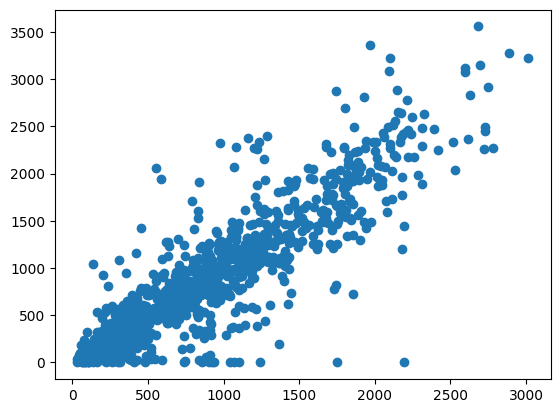

In [72]:
import matplotlib.pyplot as plt
plt.scatter(rf_predictions, y_test)

In [73]:
def calculate_smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = 0.5 * (np.abs(y_pred) + np.abs(y_true))
    percentage_diff = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    smape = np.mean(percentage_diff) * 100
    return smape

In [74]:
smape = calculate_smape(y_test, rf_predictions)
print(f'SMAPE: {smape:.2f}%')

SMAPE: 33.32%
